# Monitoring the usage of Mini CountryMan

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from datetime import datetime, timedelta
import time
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import matplotlib.lines as lines
#import cufflinks as cf
#from plotly.offline import download_plotlyjs,init_notebook_mode, plot, iplot
#cf.go_offline()

params = {'legend.fontsize': 'x-large',
         'figure.figsize': (15,5),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)
%matplotlib inline

pd.options.mode.chained_assignment = None

In [12]:
#open the csv file for miles
filename = 'MiniMiles.csv'

#get the data
mdata = pd.read_csv(filename,skiprows=0)

###Convert Datetime to format
mdata['dtime'] = pd.to_datetime(mdata.dtime,format='%Y-%m-%d %H:%M:%S')
mdata.sort_values(by='dtime')

mdata['miles_int'] = 0

nentries = len(mdata)
Miles0 = mdata.miles.min()
for i in range(1,nentries):
    mdata.miles_int.loc[i] = mdata.miles.loc[i]-mdata.miles.loc[i-1]

#mdata['mymiles'] = mdata.miles -mdata.miles[0]
#mdata['dTime'] = mdata.Data + ' ' 

### get the gas data
gfilename = 'GasRefills.csv'

gdata = pd.read_csv(gfilename)
gdata['gtime'] = pd.to_datetime(gdata.gtime,format='%Y-%m-%d %H:%M:%S')
gdata.sort_values(by='gtime')

def add_time_miles(month,day,year,hour,minute, miles):
    newdate = datetime(year, month, day, hour, minute)
    nentries = len(mdata)
    diff = miles - mdata.miles.loc[nentries-1]
    if miles < Miles0:
        print("less miles thatn the initial miles (%d), not adding entry" %Miles0)
        return;
    if diff < 0:
        print("same or lower milege (%d) as previous entry: %d, not adding point" % (miles,mdata.miles.loc[nentries-1]))
        return;
    
    
    print ('Added entry %s, %d' % (newdate, miles))
    mdata.loc[nentries] =[pd.to_datetime(newdate),miles,diff]
    return;

def add_miles(miles):
    now = datetime.now()
    add_time_miles(now.month, now.day, now.year,now.hour, now.minute, miles)
    return;

def add_gas(gallons,price,octane):
    nd = datetime.now()
    add_time_gas(nd.month, nd.day, nd.year, nd.hour,nd.minute,gallons, price,octane,'','')
    return;

def add_gas(gallons,price,octane,station,location):
    nd = datetime.now()
    add_time_gas(nd.month, nd.day, nd.year, nd.hour,nd.minute,gallons, price,octane,station,location)
    return;

def add_time_gas(month,day,year,hour,minute, gallons, price,octane,station,location):
    newdate = datetime(year, month, day, hour, minute)
    nentries = len(gdata)
        
    gdata.loc[nentries] =[pd.to_datetime(newdate),gallons, price,octane,station,location,np.NaN, np.NaN]
    return;

def save_miles():
    
    mdata.to_csv('MiniMiles.csv',sep=',',encoding='utf-8', index=False,columns=['dtime','miles'])
    return;

def save_gas():
    cols = ['gtime','gallons','price','octane','station','location','mpergal','mpertank']
    gdata.to_csv('GasRefills.csv',sep=',',encoding='utf-8', index=False,columns=cols)
    return;

# Add miles or gas data

In [5]:
#add_time_miles(month, day, year, hour, minutes, miles)
# or add_miles(miles) to add using today's timestamp
#add_time_miles(8,21,2018,20,30,9194)
#add_miles(9191)

Added entry 2018-08-21 20:30:00, 9194


In [13]:
mdata.tail(8)

,dtime,miles,miles_int
317,2018-08-17 20:30:00,9126,31
318,2018-08-18 20:30:00,9126,0
319,2018-08-19 15:15:00,9126,0
320,2018-08-20 09:59:00,9144,18
321,2018-08-20 20:30:00,9160,16
322,2018-08-21 10:38:00,9175,15
323,2018-08-21 21:42:00,9191,16
324,2018-08-22 20:30:00,9194,3


In [17]:
#add_time_gas(month, day, year,hour, minutes, gallons, price,octane)
#add_gas(gallons, price,octane,station,location)   this will add data with todays date
#add_gas(12,18,2017,10,0)
#add_gas(14.045,38.09,87,'Valero','Sugarland')

In [7]:
gdata.tail(6)

,gtime,gallons,price,octane,station,location,mpergal,mpertank
6,2018-04-05 11:44:00,13.903,31.96,91.0,Costco,Houston,29.202330,406.0
7,2018-04-24 19:15:00,14.379,34.50,87.0,Costco,Houston,30.252451,435.0
8,2018-05-22 22:14:00,14.440,38.00,87.0,Exxon,Sugarland,29.639889,428.0
9,2018-06-12 20:11:00,12.451,32.36,87.0,Costco,Houston,29.314914,365.0
10,2018-07-09 12:31:00,14.529,36.31,87.0,Costco,Houston,30.766054,447.0
11,2018-08-03 12:01:00,14.945,38.09,87.0,Valer,Sugarland,29.441285,440.0


## Save the csv data file

In [14]:
save_miles()

In [15]:
save_gas()

# Process the data

Resample the data by day 'D', get the total number of miles driven per day, and cumulative miles driven.

In [16]:
import calendar

#Get the Series data with time as an index
dt1 = pd.Series(mdata.miles_int.tolist(), index=mdata.dtime)
dt2 = pd.Series(mdata.miles.tolist(), index=mdata.dtime)

#resample the data by day, later it can be by week, or business day
max_m = dt2.resample('D').max()-Miles0;
mpday = dt1.resample('D').sum();

#merge the series into a dataframe
mpd1 = pd.DataFrame(data=mpday.values,columns=['milespd'])
mpd2 = pd.DataFrame(data=mpday.index,columns=['dtime'])
max1 = pd.DataFrame(data=max_m.values,columns=['max_miles'])
mpdt = pd.merge(mpd2,mpd1,left_index=True, right_index=True);

mpd = mpdt.merge(max1,left_index=True,right_index=True)
mpd['dtime'] = mpd['dtime'].apply(lambda x : x.date())

#add the day of the week
mpd['dayofweek'] = mpd['dtime'].apply(lambda x: x.weekday())
mpd['dayofweek'] = mpd['dayofweek'].apply(lambda x: calendar.day_name[x])

#print the last 8 days
mpd.tail(8)

,dtime,milespd,max_miles,dayofweek
240,2018-08-15,31,4785,Wednesday
241,2018-08-16,31,4816,Thursday
242,2018-08-17,31,4847,Friday
243,2018-08-18,0,4847,Saturday
244,2018-08-19,0,4847,Sunday
245,2018-08-20,34,4881,Monday
246,2018-08-21,31,4912,Tuesday
247,2018-08-22,3,4915,Wednesday


Get the miles per gallon of gas added

In [17]:
#miles per gallon of gas
#gdata['mpergal'] = 0
#gdata['mpertank'] = 0

NGas = len(gdata)
for i in range(1,NGas):
    #if (pd.isnull(gdata.mpergal.loc[i])) | (pd.isnull(gdata.mpergal.loc[i])): 
        mpg = mdata[(mdata.dtime> gdata.gtime.loc[i-1]) & (mdata.dtime<= gdata.gtime.loc[i])]
        #miles in the period
        gdata.mpergal.loc[i] = mpg.miles_int.sum()/gdata.gallons.loc[i]
        gdata.mpertank.loc[i] = mpg.miles_int.sum()
        #print(i)
gdata.tail(10)   

,gtime,gallons,price,octane,station,location,mpergal,mpertank
2,2018-01-29 19:37:00,14.179,34.02,89.0,Valero,Sugarland,29.127583,413.0
3,2018-02-14 09:35:00,13.318,29.95,87.0,Valero,Sugarland,31.160835,415.0
4,2018-03-04 12:09:00,12.875,27.28,87.0,Costco,Houston,28.737864,370.0
5,2018-03-19 08:57:00,14.812,32.57,87.0,Costco,Houston,27.545234,408.0
6,2018-04-05 11:44:00,13.903,31.96,91.0,Costco,Houston,29.202330,406.0
7,2018-04-24 19:15:00,14.379,34.50,87.0,Costco,Houston,30.252451,435.0
8,2018-05-22 22:14:00,14.440,38.00,87.0,Exxon,Sugarland,29.639889,428.0
9,2018-06-12 20:11:00,12.451,32.36,87.0,Costco,Houston,29.314914,365.0
10,2018-07-09 12:31:00,14.529,36.31,87.0,Costco,Houston,30.766054,447.0
11,2018-08-03 12:01:00,14.945,38.09,87.0,Valer,Sugarland,29.441285,440.0


In [18]:
gdata['ppg']=gdata.price/gdata.gallons;
gdata.tail()
#average miles per tank
mean_miles = gdata[gdata.mpertank>0]['mpertank'].mean();
std_miles = gdata[gdata.mpertank>0]['mpertank'].std();
#miles since last gas refill

m_since_gas = mdata[mdata.dtime > gdata.gtime.loc[NGas-1]]['miles_int'].sum()
miles_left = mean_miles - m_since_gas

print('Average miles before refills %1.1f (%1.1f).' %(mean_miles,std_miles))
print('Miles since last gas fill %1.2f, miles left %1.1f' %(m_since_gas,miles_left))

Average miles before refills 409.3 (28.5).
Miles since last gas fill 413.00, miles left -3.7


In [19]:
# get the average miles per day, 
#only counting days where we drove more than 5 miles in the past 45 days, excluding today
# in case day isn't over
end_date = datetime.today().date()
start_date = end_date + timedelta(-60) 

# get average miles per day if driven > 5 miles
avg_mpd = mpd[ (mpd['milespd']>5)  & (mpd['dtime']>start_date) & (mpd['dtime']<end_date)]['milespd'].mean();
#get average miles per day 
avg_mpd_all = mpd[  (mpd['dtime']>start_date) & (mpd['dtime']<end_date)]['milespd'].mean();

print ('Average miles per day %1.2f (above 5 miles)' % avg_mpd);
print ('Average miles per day %1.2f' % avg_mpd_all);
#mpd[ (mpd['milespd']>5)  & (mpd['dtime']>start_date) & (mpd['dtime']<end_date)]

Average miles per day 30.57 (above 5 miles)
Average miles per day 18.36


# Plot the miles vs time

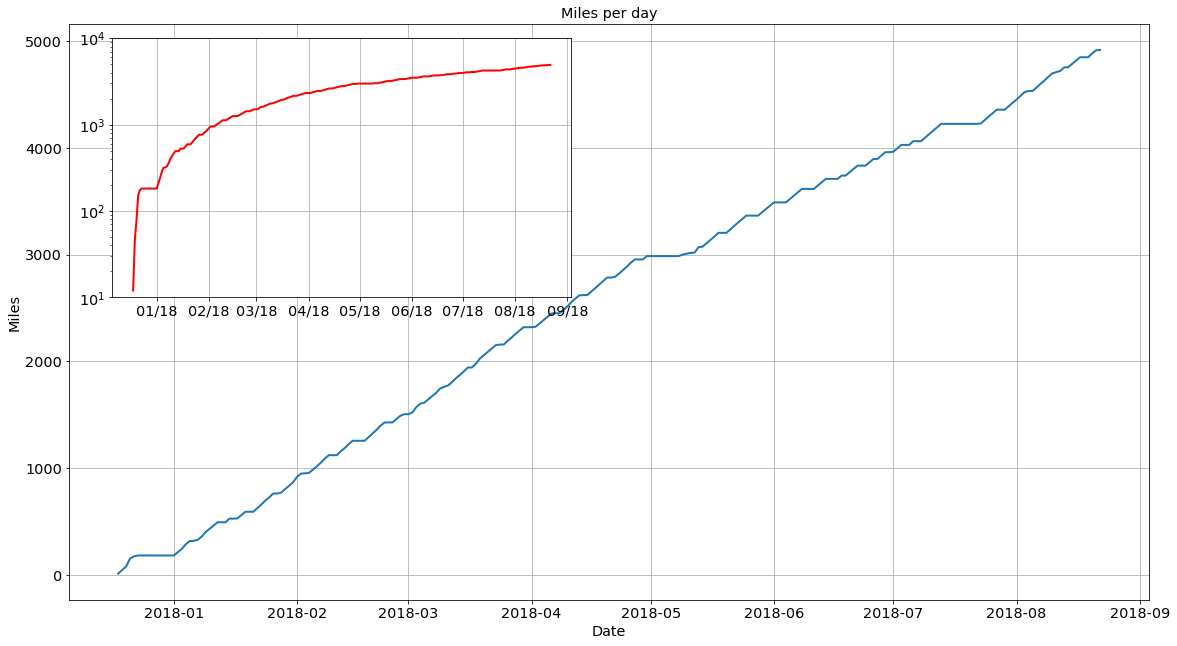

In [20]:
fig = plt.figure(2,figsize=(15,8))
axs = fig.add_axes([0,0,1,1])

axs.plot(mpd['dtime'],mpd['max_miles'],lw=2)
axs.set_title('Miles per day')
#axs.set_ylim([1e1, 3e3])
axs.set_xlabel('Date')
axs.set_ylabel('Miles')
axs.grid(True)

axs2 = fig.add_axes([0.04,0.525,.425,0.45])
axs2.plot(mpd['dtime'],mpd['max_miles'],lw=2,color='r')
axs2.semilogy()
axs2.set_ylim([1e1,10e3])
months = mdates.MonthLocator()
monthFmt = mdates.DateFormatter('%m/%y')
axs2.xaxis.set_major_locator(months)
axs2.xaxis.set_major_formatter(monthFmt)
axs2.grid(True)


#mpd.plot(x='dtime',y='max_miles',figsize=(15,8),grid=True,kind='line',
#         label='Miles per day',linewidth=2,title='Miles per day',ylim=(1e1,3.0e3))
#plt.ylabel('Miles',fontsize=18)
#plt.xlabel('Time',fontsize = 18)
##plt.semilogy()
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=12)
#plt.legend(fontsize=14)
#plt.savefig('Thermal_Profile//Temperature_1.png')
#plt.title('Mini Country',fontsize=24)

#slope, intercept, r_value, p_value, std_err = stats.linregress(mpd.dtime,mpd.max_miles)

In [31]:
#fig = plt.figure(2,figsize=(15,8))
#axs = fig.add_axes([0,0,1,1])

mpd.iplot(x='dtime',y='max_miles',xTitle='Time',yTitle='Miles',
          title='CountryMan miles',theme='pearl',width=3,color='red')

#axs.set_title('Miles per day')
#axs.set_ylim([1e1, 3e3])
#axs.set_xlabel('Date')
#axs.set_ylabel('Miles')
#axs.grid(True)

AttributeError: 'DataFrame' object has no attribute 'iplot'

In [ ]:
#mpd.milespd.iplot()
mpd['avg'] =mpd.milespd.rolling(14).mean()
mpd.iplot(x='dtime',y=['milespd','avg'])
#mpd.milespd.rolling(14).mean().plot(label='2 Week',linewidth=5)

Text(105.625,0.5,'Miles')

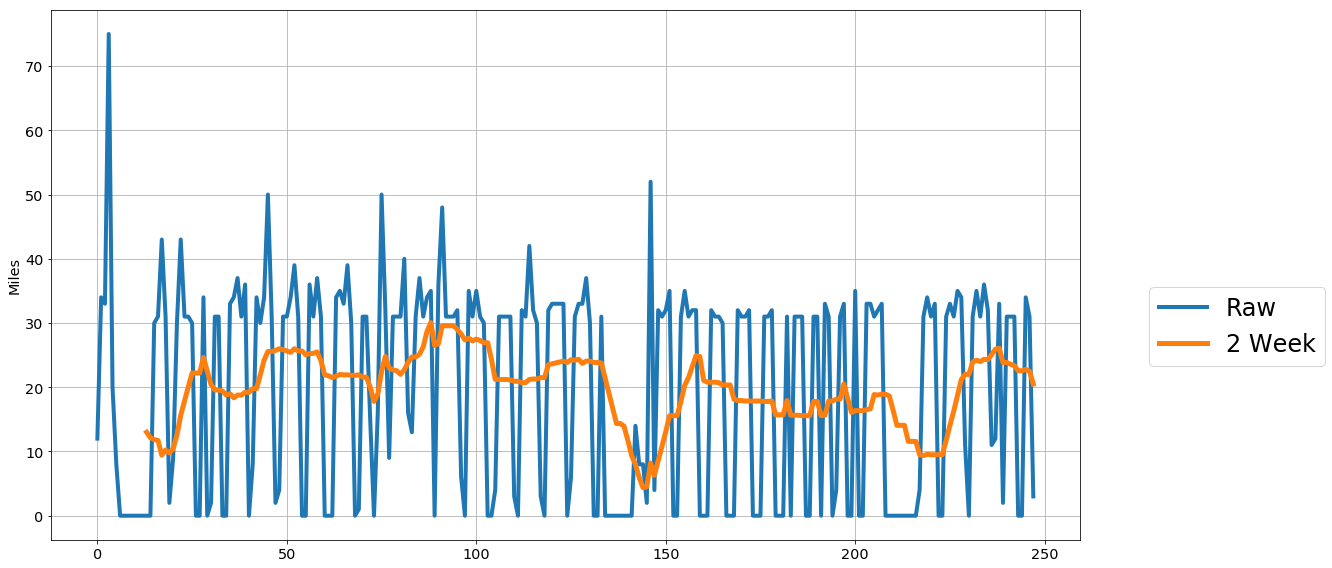

In [21]:
mpd.milespd.plot(label='Raw',grid=True,figsize=(15,8),linewidth=4)
mpd.milespd.rolling(14).mean().plot(label='2 Week',linewidth=5)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.25, .5),fontsize=24)
plt.tight_layout()
plt.ylabel("Miles")

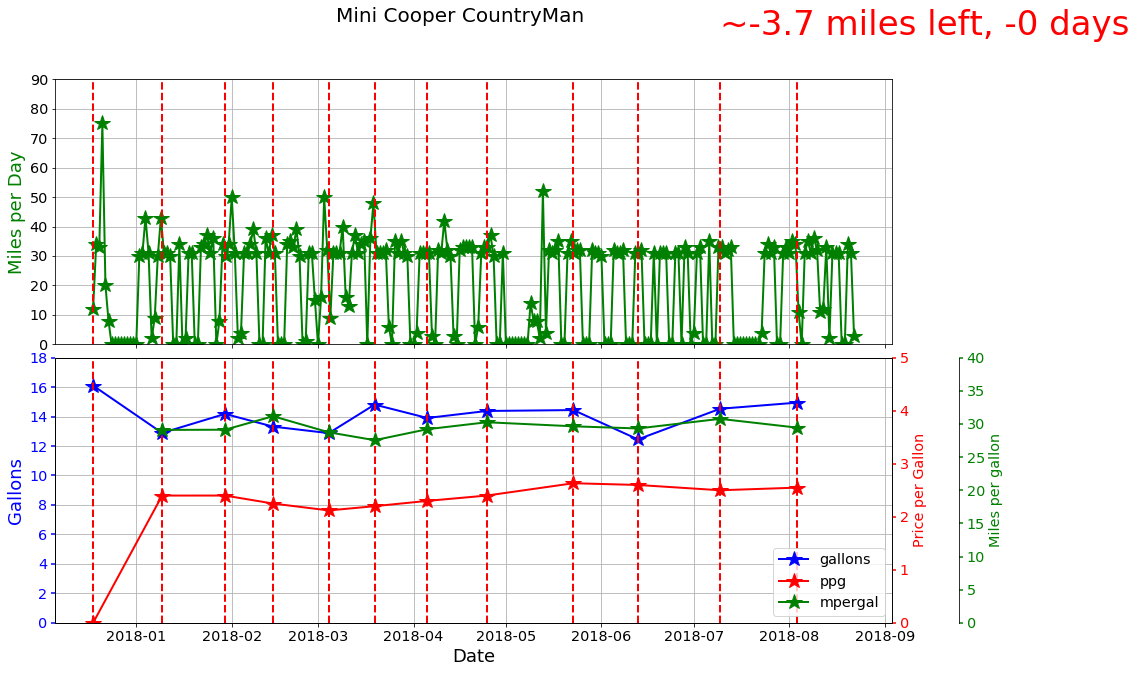

In [22]:
fig, ax1 = plt.subplots(2,sharex=True,figsize=(15,10))
#ax2 = ax1.twinx()
fig.suptitle('Mini Cooper CountryMan',fontsize=20)
ax1[0].plot(mpd.dtime, mpd.milespd,'g*-',linewidth=2,ms=16 )
#ax1[1].plot(mpd.dtime, mpd.max_miles-Miles0,'b*-',linewidth=2,ms=16)

p1,= ax1[1].plot(gdata.gtime, gdata.gallons,'b*-',linewidth=2,ms=16)
ax2 = ax1[1].twinx()
ax3 = ax1[1].twinx()


ax3.spines["right"].set_position(("axes", 1.08))
ax3.spines["right"].set_visible(True)

p2, = ax2.plot(gdata.gtime, gdata.ppg, 'r*-',linewidth=2,ms=16)
ax2.set_ylabel('Price per Gallon', color='r')
#ax3.spines["right"].set_position(("axes", 1.2)
                                 
p3, = ax3.plot(gdata.gtime, gdata.mpergal,'g*-',linewidth=2,ms=16)
ax3.set_ylabel('Miles per gallon',color='g')

#
#set the titles
ax1[0].set_ylabel('Miles per Day', color ='g',fontsize=18)
ax1[1].set_ylabel('Gallons', color ='b',fontsize=18)
ax1[1].set_xlabel('Date',fontsize=18)
ax1[0].grid(True)
ax1[1].grid(True)

#set the colors
tkw = dict(size=4, width=1.5)
ax1[1].tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax3.tick_params(axis='y', colors=p3.get_color(), **tkw)

ax1[0].set_ylim(0,90)
ax1[1].set_ylim(0,18)
ax2.set_ylim(0,5) #price per gallon
ax3.set_ylim(0,40) #miles per gallon
fig.subplots_adjust(hspace=.05)


##
#line = lines.Line2D([gdata.gtime[0], 15], [gdata.gtime[0], 35], lw=2, color='red', axes=ax1[0])
#ax1[0].add_line(line)
#l1=plt.axhline(50,color='red',ls='-')
for i in range(NGas):
    ax1[0].axvline(gdata.gtime[i], color='r', linestyle='--', lw=2)
    ax1[1].axvline(gdata.gtime[i], color='r', linestyle='--', lw=2)

    
lines = [p1, p2, p3]
ax1[1].legend(lines, [l.get_label() for l in lines])

mystr = '~{:,.1f} miles left, {:,.0f} days'.format(miles_left,miles_left/avg_mpd)
colr = 'g'
if miles_left < 60:
    colr ='orange'
if miles_left < 0:
    colr = 'red'
    
ax1[0].text(gdata.gtime.loc[NGas-2],105,mystr,fontsize=34,color=colr)

plt.show()

In [15]:
#Plot miles per trip
#gdata.gtime[0]
#fig = plt.figure(1)
#mdata[mdata.miles_int >0].plot(x='dtime',y='miles_int',figsize=(15,10),grid=True,label='Miles per trip')

In [23]:
sorter = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sorterIndex = dict(zip(sorter,range(len(sorter))))

In [24]:
milesperday = mpd.drop('max_miles',axis=1)
milesperday = milesperday.groupby('dayofweek').sum()
#milesperday.drop('max_miles',axis=1)
milesperday['dayid'] = milesperday.index
milesperday['dayid'] = milesperday['dayid'].map(sorterIndex)
milesperday.sort_values('dayid',inplace=True)
#total miles
totmiles = milesperday.milespd.sum()

In [25]:
milesperday['frac_milespd'] = milesperday['milespd']/totmiles*100.
milesperday['ndays'] = 0

for i in sorter:   
    nw = mpd.dayofweek[mpd.dayofweek == i].count()
    milesperday.ndays[milesperday.index == i] = nw
    
milesperday['avg_miles']  = milesperday.milespd/milesperday.ndays

milesperday.head(10)

,milespd,dayid,frac_milespd,ndays,avg_miles
dayofweek,,,,,
Monday,822,0,16.724313,36,22.833333
Tuesday,948,1,19.287894,36,26.333333
Wednesday,915,2,18.616480,36,25.416667
Thursday,1025,3,20.854527,35,29.285714
Friday,914,4,18.596134,35,26.114286
Saturday,114,5,2.319430,35,3.257143
Sunday,177,6,3.601221,35,5.057143


Text(0,0.5,'Avg miles')

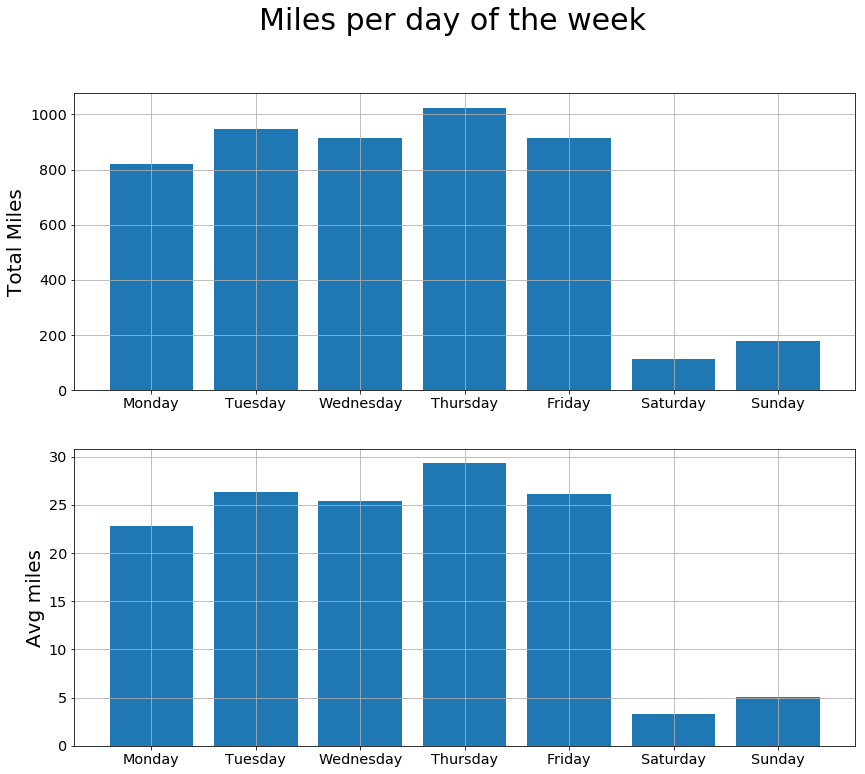

In [26]:
fig, ax= plt.subplots(2,figsize=(14,12) )
fig.suptitle('Miles per day of the week',fontsize=30)
# miles per day of the week
ax[0].bar(milesperday.dayid, milesperday.milespd)
ax[0].set_xticks([x for x in milesperday.dayid])
ax[0].set_xticklabels(milesperday.index)
ax[0].grid(True)

#ax0 = ax[0].twinx()
ax[0].set_ylabel("Total Miles", fontsize=20)
#fig.subplots_adjust(hspace=.05)


# miles per day of the week
ax[1].bar(milesperday.dayid, milesperday.avg_miles)
ax[1].set_xticks([x for x in milesperday.dayid])
ax[1].set_xticklabels(milesperday.index)
ax[1].grid(True)
ax[1].set_ylabel("Avg miles", fontsize=20)

# percentage of miles per day of the week
#ax[2].bar(milesperday.dayid, milesperday.frac_milespd)
#ax[2].set_xticks([x for x in milesperday.dayid])
#ax[2].set_xticklabels(milesperday.index)
#ax[2].grid(True)


# Compare Miles per gallon as a function of gas octane

The octane in gdata will be given by the previous entry. When the car came from the dealer, the octane in the gas was unknown. Trying to find if the octane will affect the miles per gallon

Mean miles for 89 octane 30.18 mpg 1.02
Mean miles for 87 octane 29.24 mpg 0.97


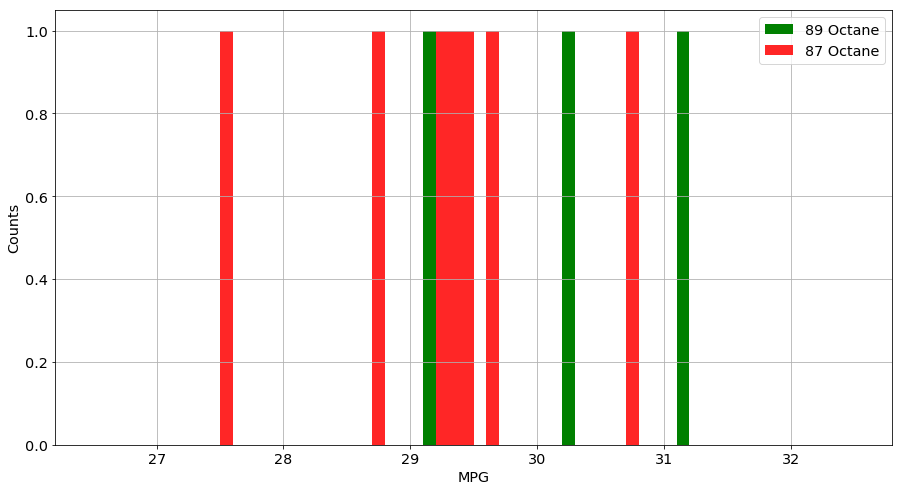

In [20]:
#gdata[gdata.octane.shift()==89]['mpergal'].plot.hist(grid=True,bins=Nbins,figsize=(15,8),alpha=0.5,xlim=(25,35));
#gdata[gdata.octane.shift()==87]['mpergal'].plot.hist(grid=True,bins=Nbins,figsize=(15,8),alpha=0.5, xlim=(25,35));
#gdata[gdata.octane.shift()==87]['mpergal'].plot.hist(grid=True,bins=Nbins);
#gdata[gdata.octane==0].mpergal.plot.hist()

d89 = gdata[gdata.octane.shift()>=89]['mpergal']
d87 = gdata[gdata.octane.shift()==87]['mpergal']


plt.figure(figsize=(15,8))
#plt.tight_layout()
plt.ylabel("Counts")
plt.xlabel("MPG")
plt.grid(True)
Nbins = 60
n, bins, patches = plt.hist(d89,range=[26.5,32.5],bins=Nbins,label='89 Octane',color='g')
n, bins, patches = plt.hist(d87,bins, label='87 Octane',alpha=0.85,color='r')
plt.legend()
mean89 =d89.mean()
std89 =d89.std()
mean87 =d87.mean()
std87 =d87.std()
print("Mean miles for 89 octane %1.2f mpg %1.2f"%(mean89,std89))
print("Mean miles for 87 octane %1.2f mpg %1.2f"%(mean87,std87))


Average miles before refills 409.3 (28.5).


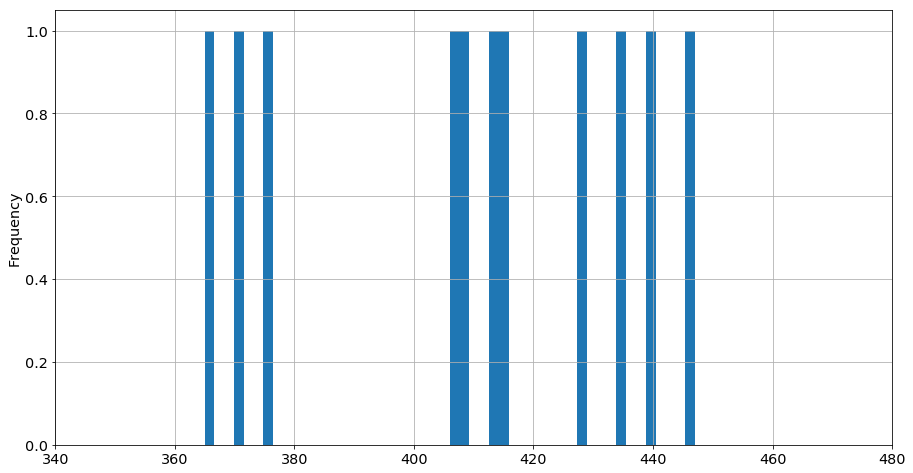

In [24]:
gdata[gdata.mpertank>0]['mpertank'].plot.hist(grid=True,bins=50,figsize=(15,8),xlim=(340,480))
print('Average miles before refills %1.1f (%1.1f).' %(mean_miles,std_miles))

In [32]:
gdata[gdata.octane>=90]
#gdata[gdata.octane.shift()==87]

,gtime,gallons,price,octane,station,location,mpergal,mpertank,ppg
6,2018-04-05 11:44:00,13.903,31.96,91.0,Costco,Houston,29.20233,406.0,2.298784


In [33]:
gdata

,gtime,gallons,price,octane,station,location,mpergal,mpertank,ppg
0,2017-12-18 00:00:00,16.100,0.00,0.0,MiniDealer,Houston,NaN,NaN,0.000000
1,2018-01-09 09:30:00,12.888,30.92,89.0,Valero,Sugarland,29.096834,375.0,2.399131
2,2018-01-29 19:37:00,14.179,34.02,89.0,Valero,Sugarland,29.127583,413.0,2.399323
3,2018-02-14 09:35:00,13.318,29.95,87.0,Valero,Sugarland,31.160835,415.0,2.248836
4,2018-03-04 12:09:00,12.875,27.28,87.0,Costco,Houston,28.737864,370.0,2.118835
5,2018-03-19 08:57:00,14.812,32.57,87.0,Costco,Houston,27.545234,408.0,2.198893
6,2018-04-05 11:44:00,13.903,31.96,91.0,Costco,Houston,29.202330,406.0,2.298784
7,2018-04-24 19:15:00,14.379,34.50,87.0,Costco,Houston,30.252451,435.0,2.399332
8,2018-05-22 22:14:00,14.440,38.00,87.0,Exxon,Sugarland,29.639889,428.0,2.631579
9,2018-06-12 20:11:00,12.451,32.36,87.0,Costco,Houston,29.314914,365.0,2.598988
